In [2]:
import sys
import os

# Add the root directory to the system path
root_dir = os.path.abspath("..")  # Assuming the notebook is one level deep in the 'notebooks' directory
if root_dir not in sys.path:
    sys.path.append(root_dir)

In [3]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, QED, Draw
import random
import matplotlib.pyplot as plt
import seaborn as sns
from src.chem.synthesis_path import print_path, draw_path
from src.chem.chem_utils import get_compound_name

# Set up seaborn style without grid lines
#sns.set(style="white", palette="muted", color_codes=True)

# Random Search: 2hrs on 2000 validation set

In [3]:
randomsearch_results = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/results/Rmolsearch_results3.csv", index_col=0)
randomsearch_results.describe()

,step,qed
count,28143.000000,28143.000000
mean,2.083147,0.418449
std,1.657722,0.273671
min,0.000000,0.005000
25%,1.000000,0.147000
50%,2.000000,0.409000
75%,3.000000,0.667000
max,5.000000,0.947000


In [5]:
randomsearch_results.head(10)

,step,reactant,template,product,qed,second_reactant
path_id,,,,,,
0,0,CC1CN(c2ccccc2F)CCN1,NaN,CC1CN(c2ccccc2F)CCN1,0.731,NaN
0,1,CC1CN(c2ccccc2F)CCN1,Reductive_amination-Ketone_R2,Cc1cc(C)c(C(C)N2CCN(c3ccccc3F)CC2C)cc1C,0.774,CC(=O)c1cc(C)c(C)cc1C
1,0,CC(=O)c1cn(CCC(=O)O)c2ccccc12,NaN,CC(=O)c1cn(CCC(=O)O)c2ccccc12,0.821,NaN
1,1,CC(=O)c1cn(CCC(=O)O)c2ccccc12,Benzothiazol_formation,CC(=O)c1cn(CCc2nc3ccc(Cl)cc3s2)c2ccccc12,0.463,Nc1cc(Cl)ccc1S
1,2,CC(=O)c1cn(CCc2nc3ccc(Cl)cc3s2)c2ccccc12,FGI_Rosenmund-von_Braun,CC(=O)c1cn(CCc2nc3ccc(C#N)cc3s2)c2ccccc12,0.509,NaN
1,3,CC(=O)c1cn(CCc2nc3ccc(C#N)cc3s2)c2ccccc12,Reductive_amination-Ketone,CC(NC1CCOC2(CCC2)C1)c1cn(CCc2nc3ccc(C#N)cc3s2)...,0.369,NC1CCOC2(CCC2)C1
1,4,CC(NC1CCOC2(CCC2)C1)c1cn(CCc2nc3ccc(C#N)cc3s2)...,Reductive_amination-Ketone_R2,CC(c1cn(CCc2nc3ccc(C#N)cc3s2)c2ccccc12)N(Cc1cc...,0.113,O=Cc1cc(Br)c([N+](=O)[O-])s1
1,5,CC(c1cn(CCc2nc3ccc(C#N)cc3s2)c2ccccc12)N(Cc1cc...,Negishi,Cc1nccc(Cl)c1-c1cc(CN(C2CCOC3(CCC3)C2)C(C)c2cn...,0.102,Cc1nccc(Cl)c1I
2,0,Nc1cc2ccc(Br)cc2nc1Cl,NaN,Nc1cc2ccc(Br)cc2nc1Cl,0.736,NaN


In [7]:
randomsearch_results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28143 entries, 0 to 6142
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   step             28143 non-null  int64  
 1   reactant         28143 non-null  object 
 2   template         22000 non-null  object 
 3   product          28143 non-null  object 
 4   qed              28143 non-null  float64
 5   second_reactant  19339 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.5+ MB


In [10]:
# Number of paths
len(randomsearch_results.index.unique())

6143

In [12]:
# Molecules with the highest qed regardless of max steps
randomsearch_results[randomsearch_results["qed"]==0.947]

,step,reactant,template,product,qed,second_reactant
path_id,,,,,,
2089,2,CNS(=O)(=O)c1ccc(-c2ccc(Cl)c(Cl)c2)s1,FGI_Rosenmund-von_Braun,CNS(=O)(=O)c1ccc(-c2ccc(Cl)c(C#N)c2)s1,0.947,NaN


In [17]:
# Paths that achieved the max number of steps (5)
randomsearch_results[randomsearch_results["step"]==5].sort_values(by='qed', ascending=False).head(20)

,step,reactant,template,product,qed,second_reactant
path_id,,,,,,
403,5,N#CCC1CCC2N=NN(C3CCC(CCNC(c4cccnc4)C4CCNCC4)CC...,Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2,CC1CC2C(CC1CO)N=NN2C1CCC(CC#N)CC1,0.868,CC1CC=CCC1CO
4199,5,CCOC(=O)c1n[nH]c(C(CS)C(C)(C)N2N=NC3CN(C(C)C)C...,Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2,CC(C)N1CCC(N2N=NC3CC(CCN)CCC32)C1,0.856,NCCC1CC=CCC1
1807,5,Cc1cc(C)c2c(n1)CCC(C(=O)C1CC1)C2=O,Cross_Claissen_R2,Cc1cc(C)c2c(n1)CCC(C(=O)C1(C(=O)C3CCNCC3)CC1)C2=O,0.840,CC(CN)OC(=O)C1CCNCC1
4603,5,CC1(c2ccccc2)CC1(N)C(=O)OCC1(CC=CC2(C(=O)OC3CC...,Cross_Claissen,CCN1C(=O)C(C(=O)C2(N)CC2(C)c2ccccc2)Cc2c(O)cccc21,0.817,CCN1C(=O)CCc2c(O)cccc21
2832,5,Cc1ccc2nc(CC3(COC4(C)CCCC4N4N=NC5C[C@@H](C(=O)...,Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2,NCCC1CC2N=NN(C3CC[C@@H](C(F)(F)F)[C@H](C(=O)O)...,0.817,NCCC1CC=CC1
2895,5,CC1(C)N=NN(C2CC(CCNS(=O)(=O)C(Cl)CCl)CCC2c2cnc...,Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2,CC(C)(CCS)N1N=NC2CCCCCC(N)C21,0.775,NC1/C=C\CCCCC1
5774,5,O=C(OCCS(=O)(=O)Nc1cc(S(=O)(=O)O)ccc1Oc1ccc(OC...,Cross_Claissen,O=C(C1CC1)C1C(=O)N(Cc2ccccc2)C[C@@H](C(=O)O)[C...,0.762,O=C(O)[C@@H]1CN(Cc2ccccc2)C(=O)C[C@H]1c1ccc(F)cc1
3024,5,CCCCCCCCC(CCc1nc2c(C#N)cc(F)cc2c(=O)n1Cc1cc(OC...,Cross_Claissen,O=C(O)[C@@]1(C(=O)CC2CC3CCC2C3)CNC[C@H]1C1CCCCC1,0.758,O=C(O)[C@@H]1CNC[C@H]1C1CCCCC1
983,5,O=C(O)C1(C(=O)C2CC2)CCCC1O,Williamson_ether_R2,O=C(O)C1(C(=O)C2CC2)CCCC1OC1CCNC1,0.726,BrC1CCNC1


In [18]:
# Find the maximum qed value for the last step of each path
last_steps = randomsearch_results.groupby('path_id').apply(lambda x: x[x['step']==x['step'].max()])
max_qed_last_step = last_steps.loc[last_steps['qed'].idxmax()]
max_qed_last_step

step                                                       1
reactant                             O=C(O)c1cnoc1-c1ccccc1F
template                                     Amide_formation
product            O=C(N[C@H]1C[C@H](CF)C1)c1cnoc1-c1ccccc1F
qed                                                    0.942
second_reactant                          N[C@H]1C[C@H](CF)C1
Name: (2952, 2952), dtype: object

In [26]:
last_steps.sort_values(by='qed', ascending=False).head(30)

,,step,reactant,template,product,qed,second_reactant
path_id,path_id,,,,,,
2952,2952,1,O=C(O)c1cnoc1-c1ccccc1F,Amide_formation,O=C(N[C@H]1C[C@H](CF)C1)c1cnoc1-c1ccccc1F,0.942,N[C@H]1C[C@H](CF)C1
3201,3201,1,c1n[nH]c([C@@H]2CCCN2)n1,Reductive_amination-Ketone_R2,COc1ccc2c(c1)C(N1CCC[C@H]1c1ncn[nH]1)CCS2,0.942,COc1ccc2c(c1)C(=O)CCS2
2346,2346,1,CSC1(C(=O)O)CCC1,Benzimidazol_formation,CCn1c(C2(SC)CCC2)nc2cc(C(N)=O)ccc21,0.941,CCNc1ccc(C(N)=O)cc1N
4441,4441,1,BrCC1CC2CCC1CC2,Negishi_R2,O=c1nn[nH]n1-c1ccc(CC2CC3CCC2CC3)cc1,0.940,O=c1nn[nH]n1-c1ccc(Br)cc1
2803,2803,1,O=c1ccc(C2CCNC2)n[nH]1,Reductive_amination-Ketone_R2,Cc1ncc(C(C)N2CCC(c3ccc(=O)[nH]n3)C2)s1,0.940,CC(=O)c1cnc(C)s1
2059,2059,1,COC1CC(=O)C12CCC2,Reductive_amination-Ketone,COC1CC(N2CCC(c3c[nH]c4cccnc34)CC2)C12CCC2,0.935,c1cnc2c(C3CCNCC3)c[nH]c2c1
3904,3904,1,O=C(O)C1CCC(C(F)F)CC1,Benzimidazol_formation,CCn1c(C2CCC(C(F)F)CC2)nc2cc(C(N)=O)ccc21,0.933,CCNc1ccc(C(N)=O)cc1N
5954,5954,1,CNc1cc(C(C)C)[nH]n1,Reductive_amination-Ketone_R2,Cc1ncc(C(C)N(C)c2cc(C(C)C)[nH]n2)c(C)n1,0.929,CC(=O)c1cnc(C)nc1C
492,492,1,COc1cc(Br)nc(OC)n1,Negishi_R2,CNC(=O)c1c(F)cccc1-c1cc(OC)nc(OC)n1,0.927,CNC(=O)c1c(F)cccc1Br


In [28]:
last_steps.sort_values(by='qed', ascending=False).tail(10)

,,step,reactant,template,product,qed,second_reactant
path_id,path_id,,,,,,
3408,3408,5,CCOC(=O)C(Cc1ccccc1)C(=O)C(COCCOCCO[Si](C)(C)C...,Ketone_formation_R2,CCOC(=O)C(Cc1ccccc1)C(=O)C(COCCOCCO[Si](C)(C)C...,0.010,CC1(CI)CC1(Cl)Cl
4722,4722,5,CCCCNC(=O)c1c(C(=O)Nc2cc(S(=O)(=O)O)ccc2OC(=O)...,Reductive_amination-Ketone_R2,CCCCCC(=O)Nc1ccc(C(CCl)Nc2cc(S(=O)(=O)O)ccc2Oc...,0.010,CCCCCC(=O)Nc1ccc(C(=O)CCl)cc1
5735,5735,5,CCCCCCCCC(CCC(=O)[O-])N(Cc1cc(-c2ccc(F)cc2)on1...,Oxadiazole_formation,CCCCCCCCC(CCc1nc(-c2ccc(OCCCCl)cc2)no1)N(Cc1cc...,0.009,N#Cc1ccc(OCCCCl)cc1
4175,4175,5,CC(C)Oc1ccc(C(=O)O)cc1C(C)Nc1cc(S(=O)(=O)O)ccc...,Mitsunobu_carboxlyic_acid,CC(C)Oc1ccc(C(=O)OCCNCCOCC(F)(F)F)cc1C(C)Nc1cc...,0.009,OCCNCCOCC(F)(F)F
5698,5698,5,CCOc1c(Cc2ccccc2)c(=O)oc2c(CNc3ccc(C4(CNS(=O)(...,Reductive_amination-Ketone_R2,C=C1CC(CN(Cc2cc(COCCOc3ccc([N+](=O)[O-])cc3C)c...,0.009,C=C1CC(C=O)(C(=O)OCC)C1
2565,2565,5,C#Cc1cccc(N(Cc2ccncc2)C(c2ccc(NC(=O)C(=O)OCC)c...,Cross_Claissen_R2,C#Cc1cccc(N(Cc2ccncc2)C(c2ccc(NC(=O)C(=O)OCC)c...,0.008,CCOC(=O)Cc1nc2c([nH]1)CNCC2
1932,1932,5,COC1CC(N(Cc2cc(CCl)ccc2OC(=O)CC(C)(O)CNC(=O)OC...,Cross_Claissen_R2,COC1CC(N(Cc2cc(CCl)ccc2OC(=O)C(C(=O)[C@H](CCC(...,0.008,CC(C)(C)OC(=O)[C@H](CCC(=O)O)NC(=O)OCC1c2ccccc...
349,349,5,CCCCCCCCC(=CCCCCCCC(C(=O)C[C@H](O)CC#N)C(=O)OC...,Peachmann_coumarine_R2,CCCCCCCCC(=CCCCCCCc1c(C[C@H](O)CC#N)c2c(C=CC(=...,0.008,O=C(O)C=Cc1ccc(C(F)(F)F)c(O)c1
1622,1622,5,CCC1(CN2CCC(C(=O)CC(=O)c3cc(-c4ccc(-c5cc(C(F)F...,Cross_Claissen_R2,CCC1(CN2CCC(C(=O)CC(=O)c3cc(-c4ccc(-c5cc(C(F)F...,0.007,CC(C)(C)OC(=O)[C@@H](N)CS


In [21]:
# Calculate the number of unique products
unique_products_count = randomsearch_results['product'].nunique()

# Display the result
print(f'The number of non-repetitive (unique) products is: {unique_products_count}')

The number of non-repetitive (unique) products is: 23625


In [22]:
# Filter the DataFrame for step 0
df_step_0 = randomsearch_results[randomsearch_results['step'] == 0]


# Calculate the number of unique reactants
unique_reactants_count_step_0 = df_step_0["reactant"].nunique()

# Display the result
print(f'The number of unique initial reactants in is: {unique_reactants_count_step_0}')

The number of unique initial reactants in is: 1903


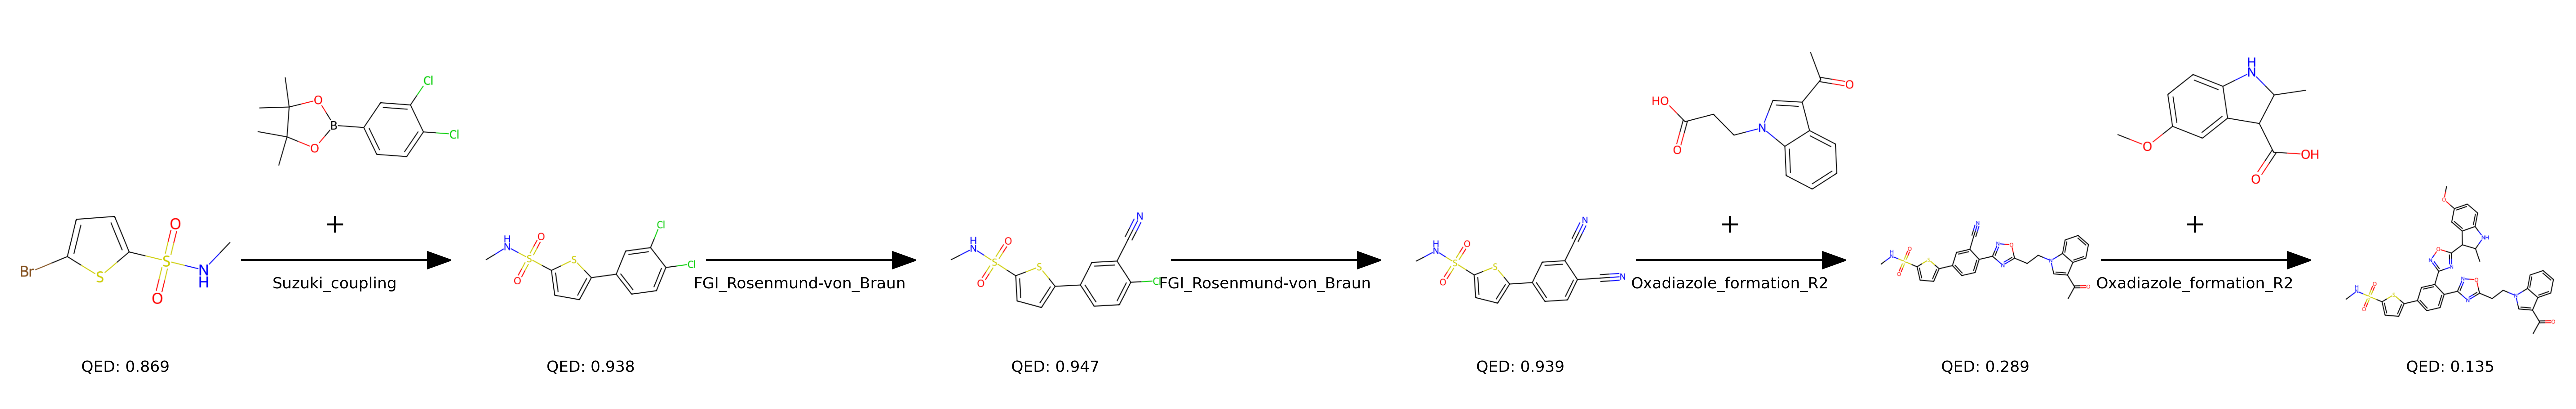

In [57]:
draw_path(randomsearch_results, 2089)

In [23]:
# display path with highest qed
print_path(randomsearch_results, 2952)

Synthesis Path ID: 2952
Step 0:
  Reactant: O=C(O)c1cnoc1-c1ccccc1F | Name: 5-(2-fluorophenyl)-1,2-oxazole-4-carboxylic acid
  Template: nan
  Product: O=C(O)c1cnoc1-c1ccccc1F | Name: 5-(2-fluorophenyl)-1,2-oxazole-4-carboxylic acid
  QED Score: 0.819
----------------------------------------
Step 1:
  Reactant: O=C(O)c1cnoc1-c1ccccc1F | Name: 5-(2-fluorophenyl)-1,2-oxazole-4-carboxylic acid
  Second Reactant: N[C@H]1C[C@H](CF)C1 | Name: 3-(fluoromethyl)cyclobutan-1-amine
  Template: Amide_formation
  Product: O=C(N[C@H]1C[C@H](CF)C1)c1cnoc1-c1ccccc1F | Name: Molecule not in PubChem Database
  QED Score: 0.942
----------------------------------------


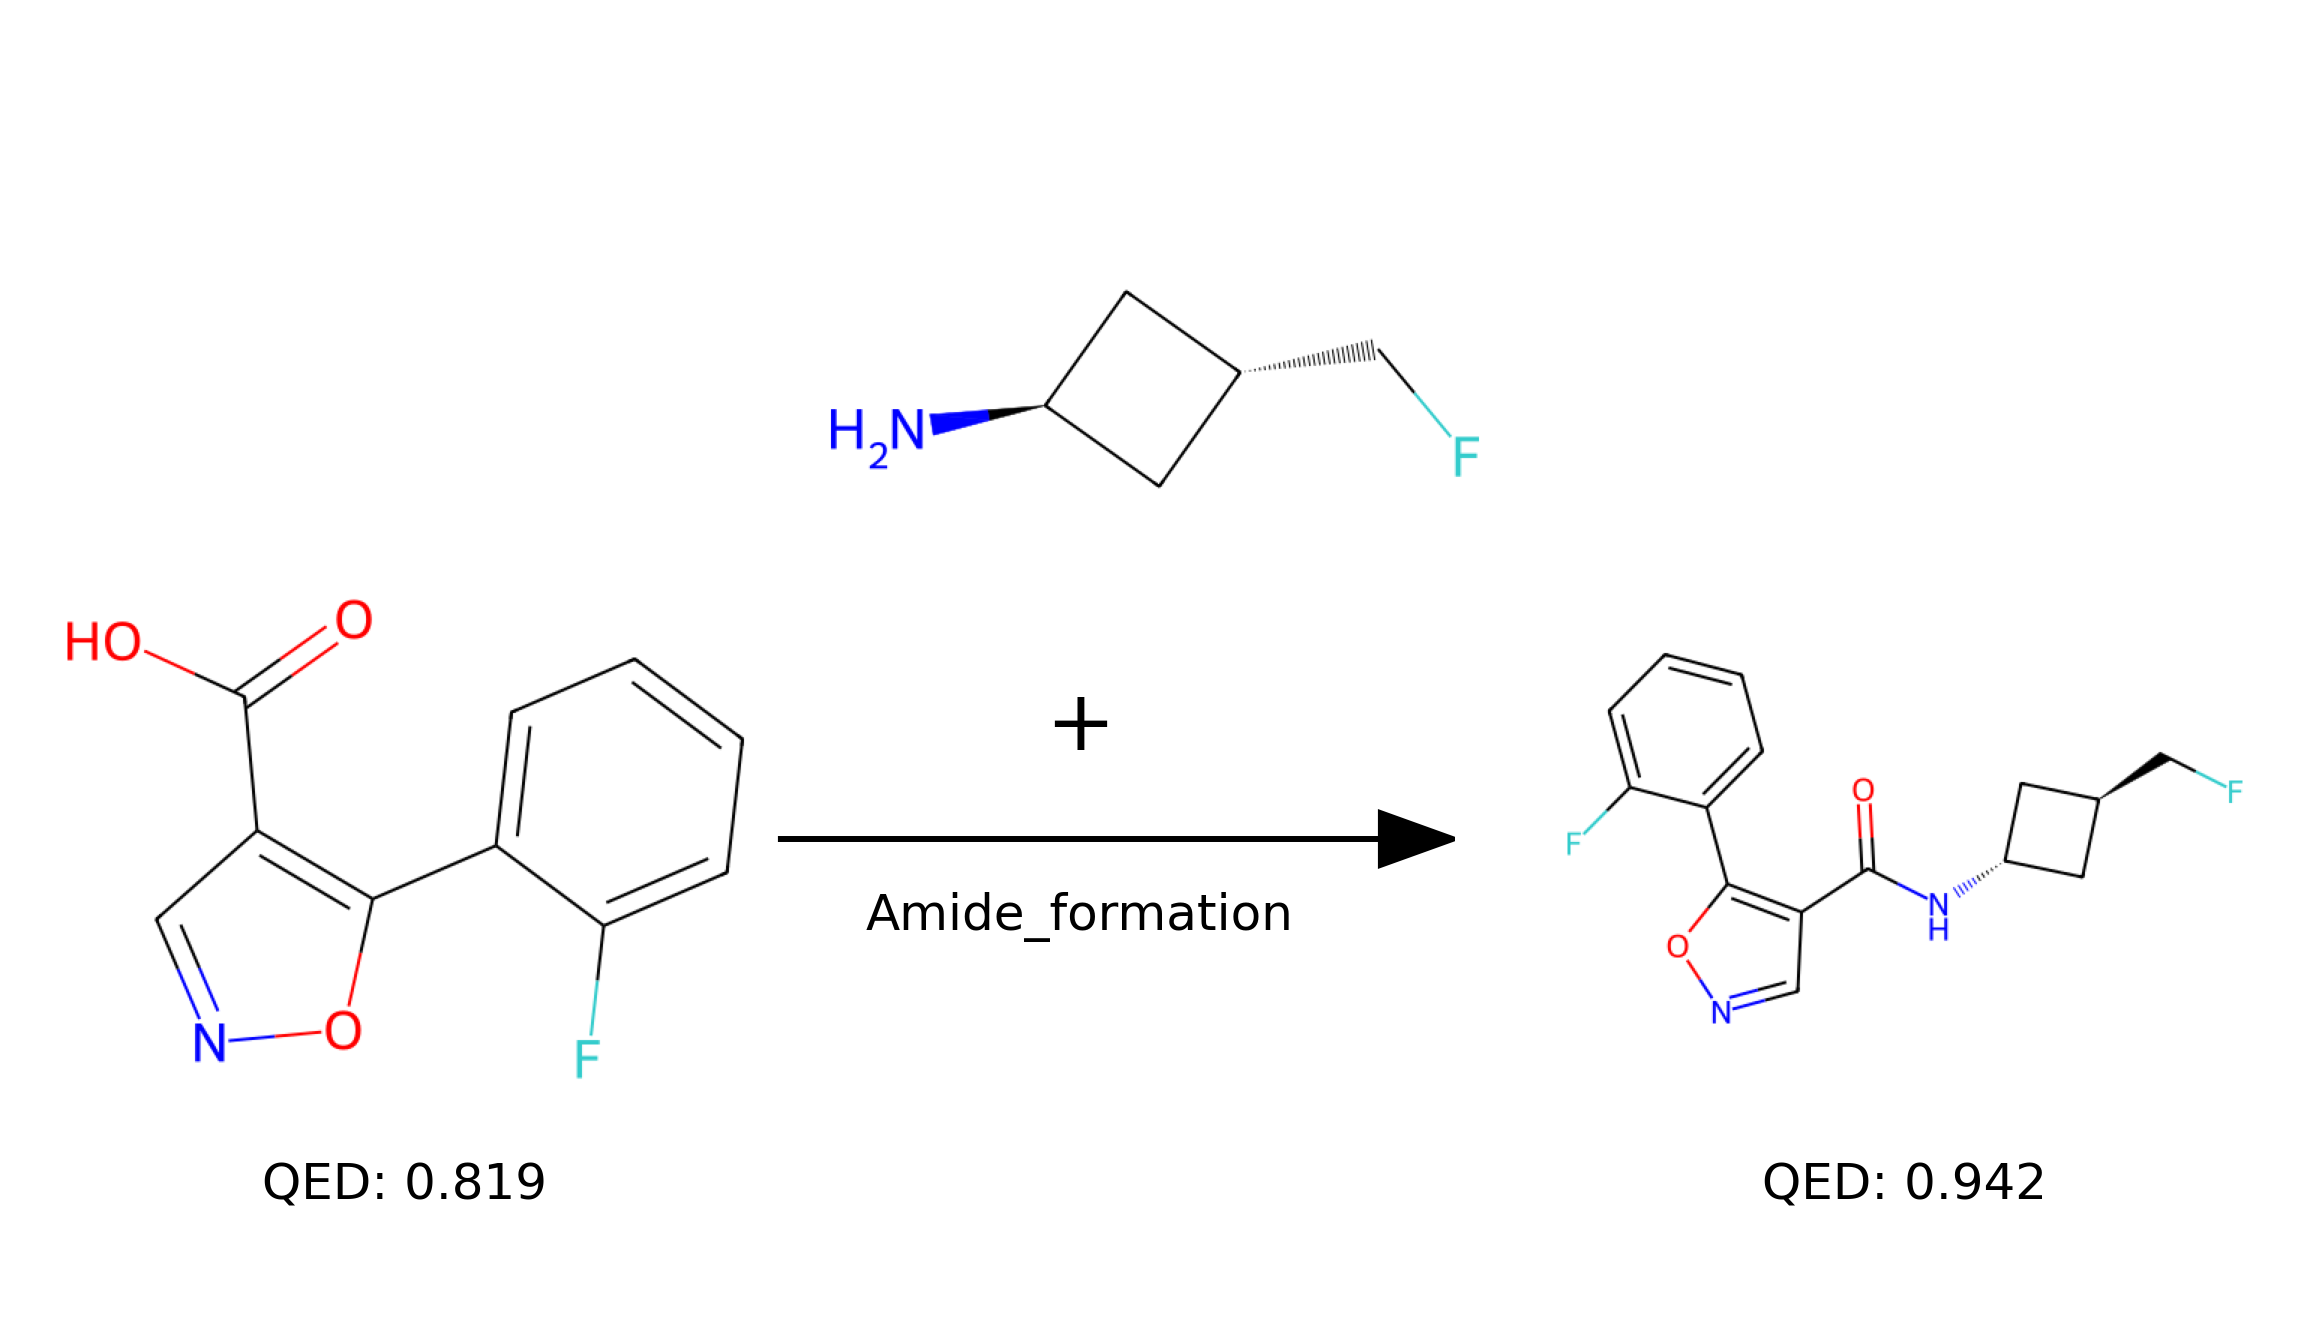

In [25]:
# synthesis path for molecule with highest qed
draw_path(randomsearch_results, 2952)

In [27]:
# display path with high qed
print_path(randomsearch_results, 3349)

Synthesis Path ID: 3349
Step 0:
  Reactant: CC(C)C(O)c1ccc2c(c1)CCCC2 | Name: 2-methyl-1-(5,6,7,8-tetrahydronaphthalen-2-yl)propan-1-ol
  Template: nan
  Product: CC(C)C(O)c1ccc2c(c1)CCCC2 | Name: 2-methyl-1-(5,6,7,8-tetrahydronaphthalen-2-yl)propan-1-ol
  QED Score: 0.784
----------------------------------------
Step 1:
  Reactant: CC(C)C(O)c1ccc2c(c1)CCCC2 | Name: 2-methyl-1-(5,6,7,8-tetrahydronaphthalen-2-yl)propan-1-ol
  Template: FGI_chlorination
  Product: CC(C)C(Cl)c1ccc2c(c1)CCCC2 | Name: 6-(1-chloro-2-methylpropyl)-1,2,3,4-tetrahydronaphthalene
  QED Score: 0.647
----------------------------------------
Step 2:
  Reactant: CC(C)C(Cl)c1ccc2c(c1)CCCC2 | Name: 6-(1-chloro-2-methylpropyl)-1,2,3,4-tetrahydronaphthalene
  Second Reactant: OC[C@@H](O)c1c[nH]nn1 | Name: (1S)-1-(2H-triazol-4-yl)ethane-1,2-diol
  Template: Williamson_ether
  Product: CC(C)C(O[C@H](CO)c1c[nH]nn1)c1ccc2c(c1)CCCC2 | Name: Molecule not in PubChem Database
  QED Score: 0.859
---------------------------------

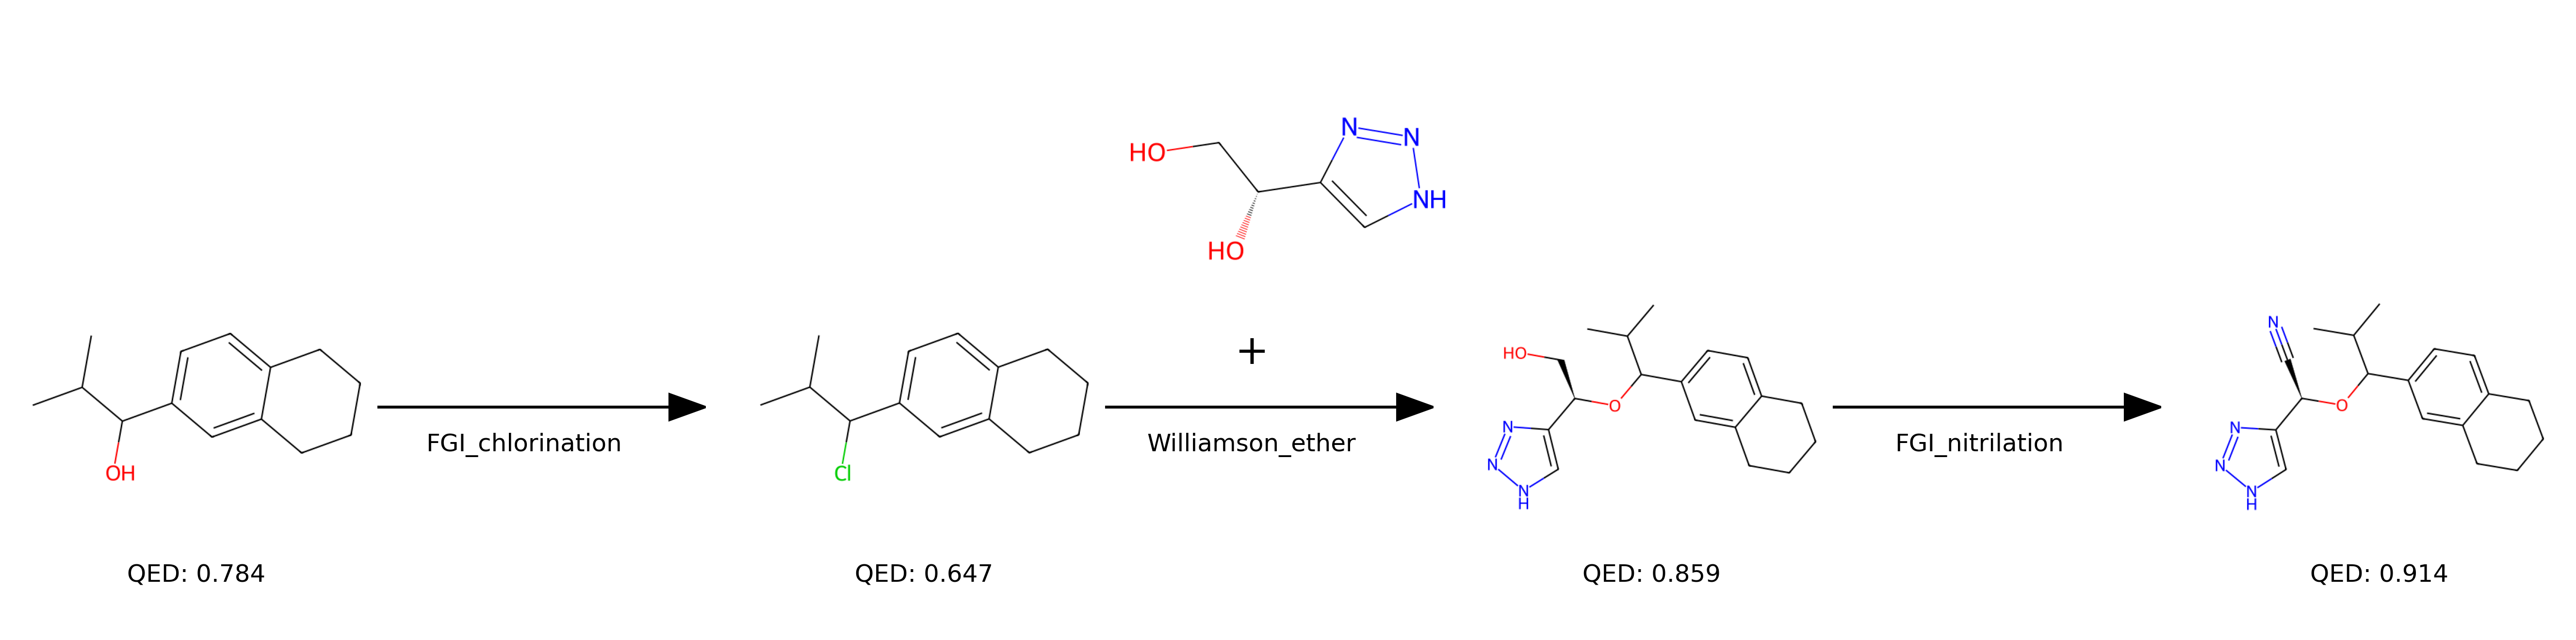

In [29]:
draw_path(randomsearch_results, 3349)

In [30]:
# display path with lowest qed
print_path(randomsearch_results, 1453)

Synthesis Path ID: 1453
Step 0:
  Reactant: Cc1sc2[nH]c(-c3ccc(C(=O)O)cc3)nc(=N)c2c1C | Name: 4-(4-amino-5,6-dimethylthieno[2,3-d]pyrimidin-2-yl)benzoic acid
  Template: nan
  Product: Cc1sc2[nH]c(-c3ccc(C(=O)O)cc3)nc(=N)c2c1C | Name: 4-(4-amino-5,6-dimethylthieno[2,3-d]pyrimidin-2-yl)benzoic acid
  QED Score: 0.679
----------------------------------------
Step 1:
  Reactant: Cc1sc2[nH]c(-c3ccc(C(=O)O)cc3)nc(=N)c2c1C | Name: 4-(4-amino-5,6-dimethylthieno[2,3-d]pyrimidin-2-yl)benzoic acid
  Second Reactant: CC(C)(C)[Si](C)(C)OCCOCCOCCI | Name: tert-butyl-[2-[2-(2-iodoethoxy)ethoxy]ethoxy]-dimethylsilane
  Template: Ketone_formation_R2
  Product: Cc1sc2[nH]c(-c3ccc(C(=O)CCOCCOCCO[Si](C)(C)C(C)(C)C)cc3)nc(=N)c2c1C | Name: Molecule not in PubChem Database
  QED Score: 0.17
----------------------------------------
Step 2:
  Reactant: Cc1sc2[nH]c(-c3ccc(C(=O)CCOCCOCCO[Si](C)(C)C(C)(C)C)cc3)nc(=N)c2c1C | Name: Molecule not in PubChem Database
  Second Reactant: CC(C)(C)OC(=O)[C@@H](N)CS | Nam

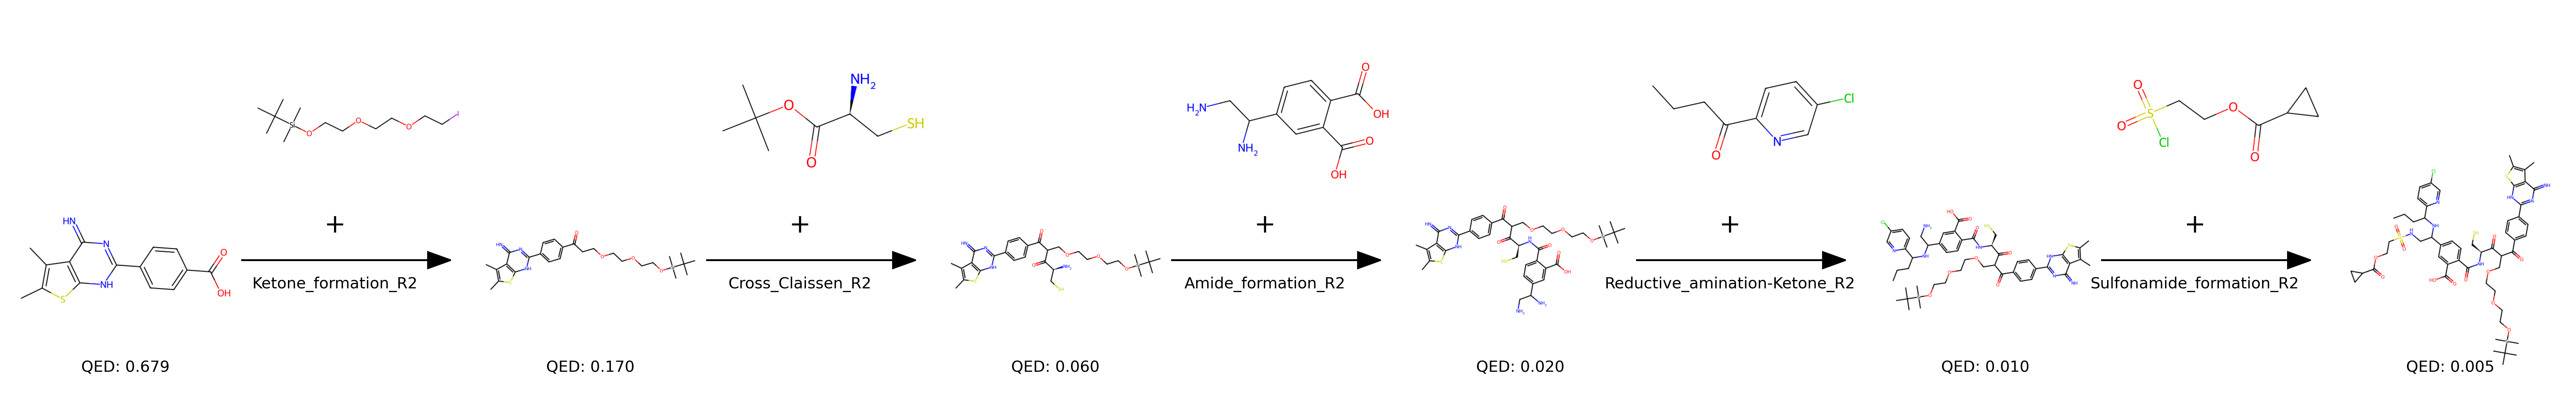

In [31]:
# Synthesis path with lowest qed
draw_path(randomsearch_results, 1453)

In [33]:
# Paths that achieved the max number of steps (5)
last_steps[last_steps["step"]==5].sort_values(by='qed', ascending=False).head(10)

,,step,reactant,template,product,qed,second_reactant
path_id,path_id,,,,,,
403,403,5,N#CCC1CCC2N=NN(C3CCC(CCNC(c4cccnc4)C4CCNCC4)CC...,Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2,CC1CC2C(CC1CO)N=NN2C1CCC(CC#N)CC1,0.868,CC1CC=CCC1CO
4199,4199,5,CCOC(=O)c1n[nH]c(C(CS)C(C)(C)N2N=NC3CN(C(C)C)C...,Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2,CC(C)N1CCC(N2N=NC3CC(CCN)CCC32)C1,0.856,NCCC1CC=CCC1
1807,1807,5,Cc1cc(C)c2c(n1)CCC(C(=O)C1CC1)C2=O,Cross_Claissen_R2,Cc1cc(C)c2c(n1)CCC(C(=O)C1(C(=O)C3CCNCC3)CC1)C2=O,0.840,CC(CN)OC(=O)C1CCNCC1
4603,4603,5,CC1(c2ccccc2)CC1(N)C(=O)OCC1(CC=CC2(C(=O)OC3CC...,Cross_Claissen,CCN1C(=O)C(C(=O)C2(N)CC2(C)c2ccccc2)Cc2c(O)cccc21,0.817,CCN1C(=O)CCc2c(O)cccc21
2832,2832,5,Cc1ccc2nc(CC3(COC4(C)CCCC4N4N=NC5C[C@@H](C(=O)...,Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2,NCCC1CC2N=NN(C3CC[C@@H](C(F)(F)F)[C@H](C(=O)O)...,0.817,NCCC1CC=CC1
2895,2895,5,CC1(C)N=NN(C2CC(CCNS(=O)(=O)C(Cl)CCl)CCC2c2cnc...,Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2,CC(C)(CCS)N1N=NC2CCCCCC(N)C21,0.775,NC1/C=C\CCCCC1
5774,5774,5,O=C(OCCS(=O)(=O)Nc1cc(S(=O)(=O)O)ccc1Oc1ccc(OC...,Cross_Claissen,O=C(C1CC1)C1C(=O)N(Cc2ccccc2)C[C@@H](C(=O)O)[C...,0.762,O=C(O)[C@@H]1CN(Cc2ccccc2)C(=O)C[C@H]1c1ccc(F)cc1
3024,3024,5,CCCCCCCCC(CCc1nc2c(C#N)cc(F)cc2c(=O)n1Cc1cc(OC...,Cross_Claissen,O=C(O)[C@@]1(C(=O)CC2CC3CCC2C3)CNC[C@H]1C1CCCCC1,0.758,O=C(O)[C@@H]1CNC[C@H]1C1CCCCC1
983,983,5,O=C(O)C1(C(=O)C2CC2)CCCC1O,Williamson_ether_R2,O=C(O)C1(C(=O)C2CC2)CCCC1OC1CCNC1,0.726,BrC1CCNC1


In [34]:
# display path with lowest qed
print_path(randomsearch_results, 403)

Synthesis Path ID: 403
Step 0:
  Reactant: C=C(CC)CN=[N+]=[N-] | Name: 2-(azidomethyl)but-1-ene
  Template: nan
  Product: C=C(CC)CN=[N+]=[N-] | Name: 2-(azidomethyl)but-1-ene
  QED Score: 0.232
----------------------------------------
Step 1:
  Reactant: C=C(CC)CN=[N+]=[N-] | Name: 2-(azidomethyl)but-1-ene
  Second Reactant: NCCC1CC=CCC1 | Name: 2-cyclohex-3-en-1-ylethanamine
  Template: Huisgen_1_3_Dipolar_Cycloaddition_double_bond_R2
  Product: C=C(CC)CN1N=NC2CCC(CCN)CC21 | Name: Molecule not in PubChem Database
  QED Score: 0.746
----------------------------------------
Step 2:
  Reactant: C=C(CC)CN1N=NC2CCC(CCN)CC21 | Name: Molecule not in PubChem Database
  Second Reactant: O=C(c1cccnc1)C1CCNCC1 | Name: piperidin-4-yl(pyridin-3-yl)methanone
  Template: Reductive_amination-Ketone_R2
  Product: C=C(CC)CN1N=NC2CCC(CCNC(c3cccnc3)C3CCNCC3)CC21 | Name: Molecule not in PubChem Database
  QED Score: 0.596
----------------------------------------
Step 3:
  Reactant: C=C(CC)CN1N=NC2CCC(CCN

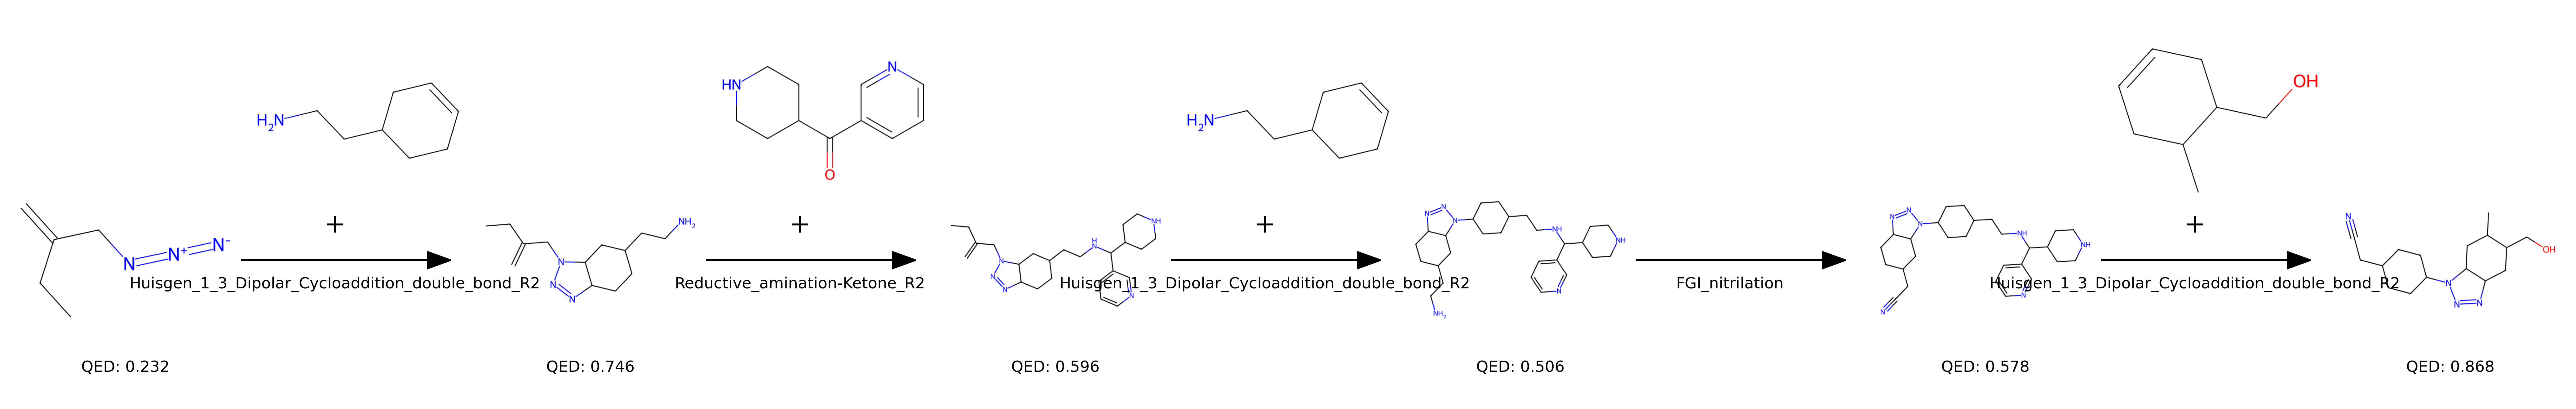

In [35]:
# Synthesis path
draw_path(randomsearch_results, 403)

## Data Analysis

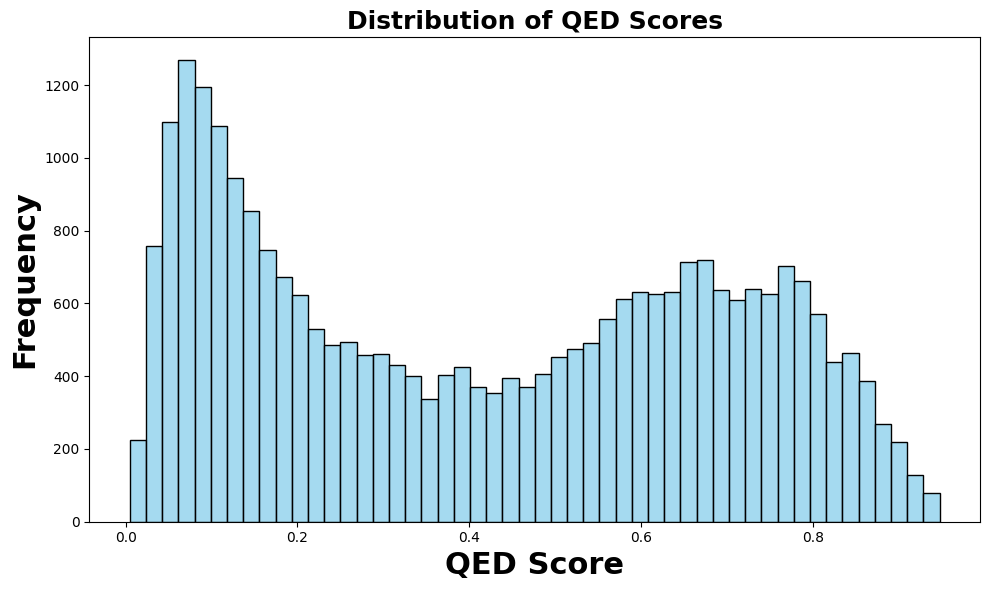

In [36]:
# Distribution of QED scores
plt.figure(figsize=(10, 6))
sns.histplot(randomsearch_results['qed'].dropna(), bins=50, kde=False, color='skyblue')
plt.title('Distribution of QED Scores', fontsize=18, fontweight='bold')
plt.xlabel('QED Score', fontsize=22, fontweight='bold')
plt.ylabel('Frequency', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

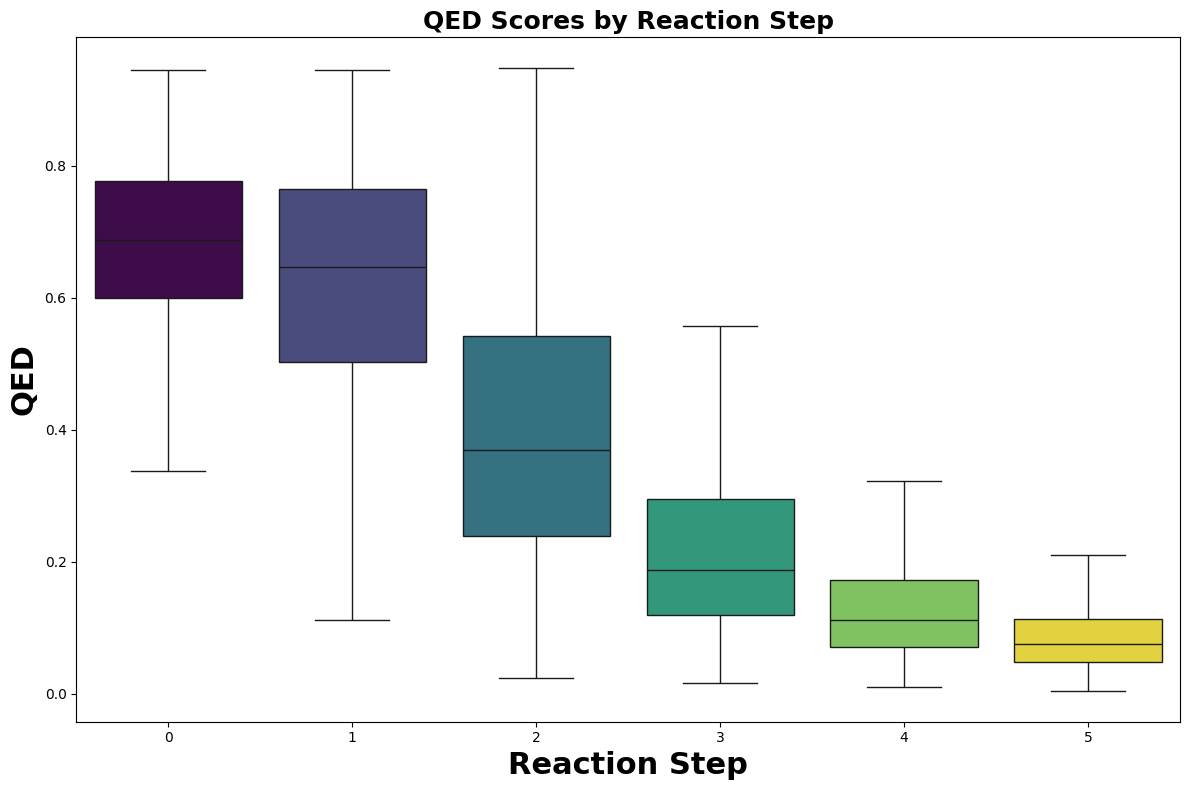

In [37]:
# Box plot for QED scores by reaction step with customized settings to avoid FutureWarning
plt.figure(figsize=(12, 8))
sns.boxplot(x='step', y='qed', data=randomsearch_results, hue='step', palette="viridis", showfliers=False, dodge=False)
plt.legend([], [], frameon=False)  # Remove legend
plt.title('QED Scores by Reaction Step', fontsize=18, fontweight='bold')
plt.xlabel('Reaction Step', fontsize=22, fontweight='bold')
plt.ylabel('QED', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

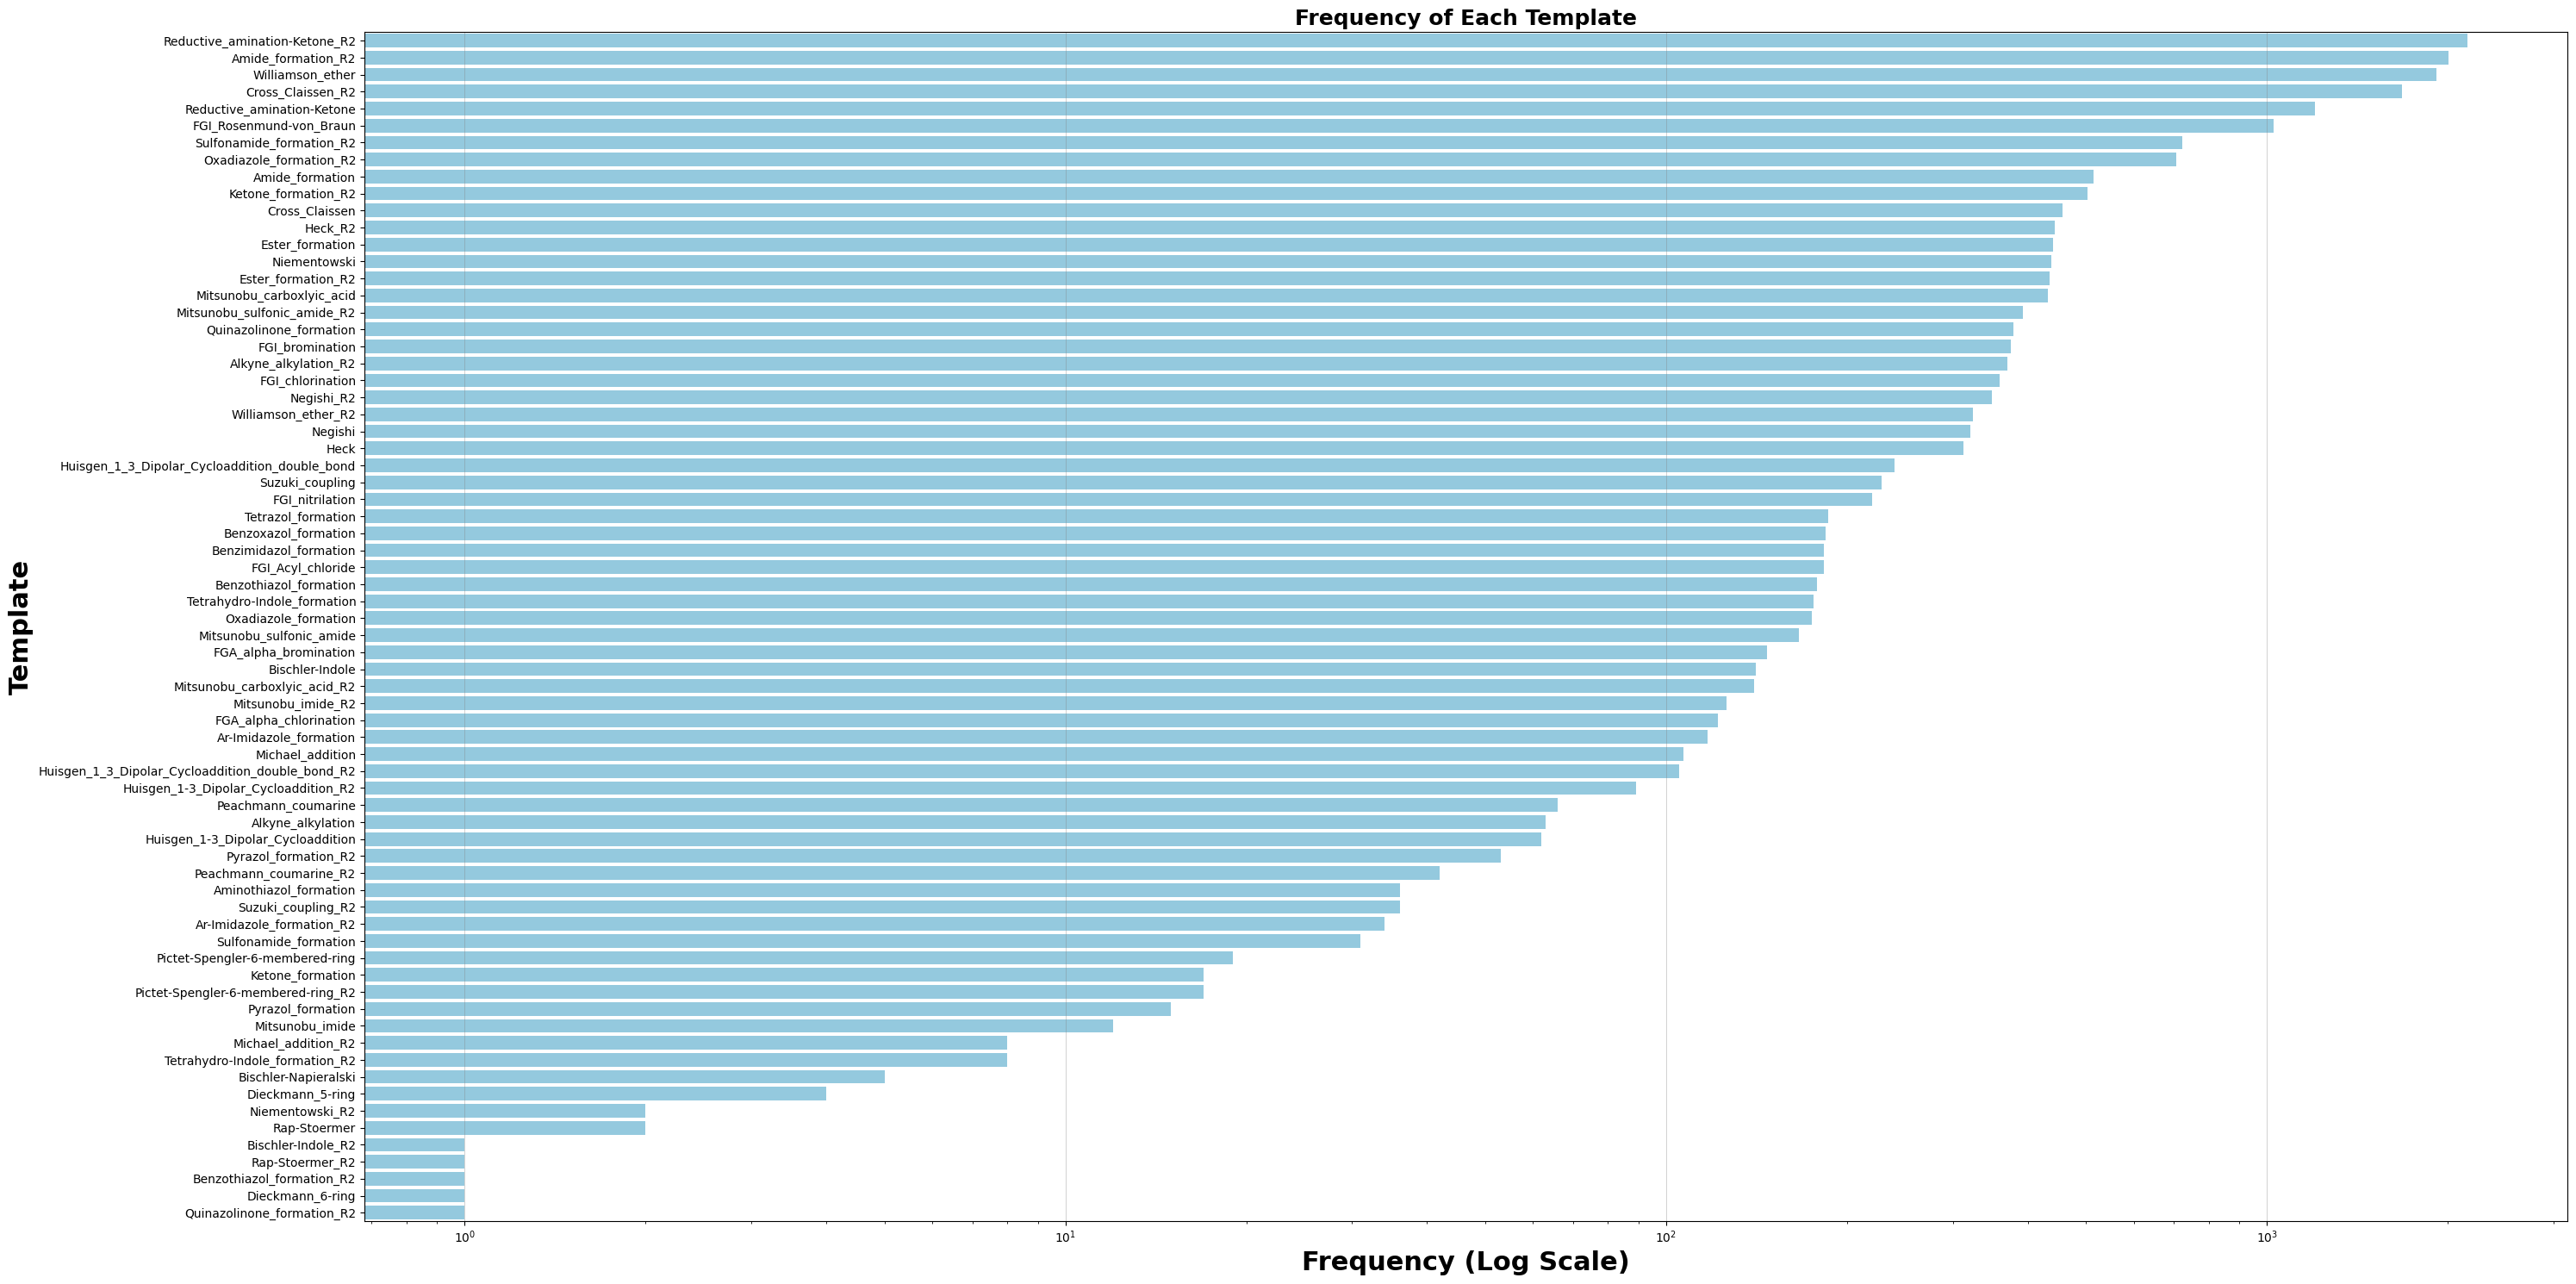

In [39]:
# Calculate frequency of each template
template_frequency = randomsearch_results['template'].value_counts().reset_index()
template_frequency.columns = ['template', 'frequency']

# Create horizontal bar plot with log scale for frequency
plt.figure(figsize=(30, 15))
sns.barplot(y='template', x='frequency', data=template_frequency, color='skyblue')
plt.xscale('log')
plt.title('Frequency of Each Template', fontsize=18, fontweight='bold')
plt.xlabel('Frequency (Log Scale)', fontsize=22, fontweight='bold')
plt.ylabel('Template', fontsize=22, fontweight='bold')
# Add faint grey grid lines
plt.grid(color='grey', linestyle='-', linewidth=0.5, axis='x', alpha=0.5)
plt.tight_layout()
plt.show()

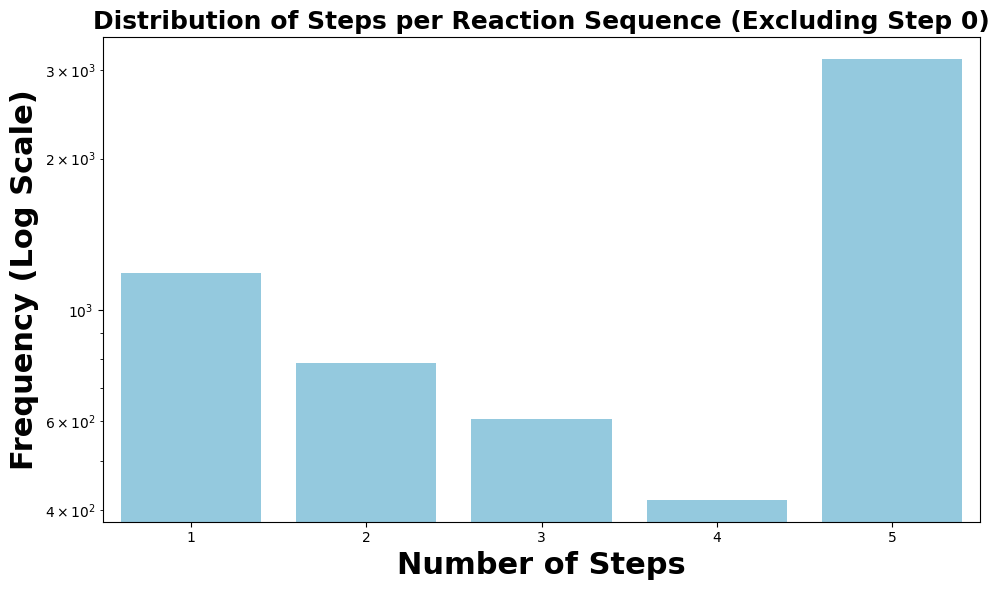

In [40]:
# Filter out step 0
df_filtered = randomsearch_results[randomsearch_results['step'] != 0]

# Calculate the number of steps per reaction sequence
steps_per_sequence = df_filtered.groupby('path_id')['step'].max()

# Calculate the frequency of each number of steps
steps_frequency = steps_per_sequence.value_counts().sort_index()

# Create a bar chart with log scale for frequency
plt.figure(figsize=(10, 6))
sns.barplot(x=steps_frequency.index, y=steps_frequency.values, color='skyblue')
plt.yscale('log')
plt.title('Distribution of Steps per Reaction Sequence (Excluding Step 0)', fontsize=18, fontweight='bold')
plt.xlabel('Number of Steps', fontsize=22, fontweight='bold')
plt.ylabel('Frequency (Log Scale)', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

/tmp/ipykernel_1922726/1185886409.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["reactant"] = data['reactant'].apply(get_compound_name)


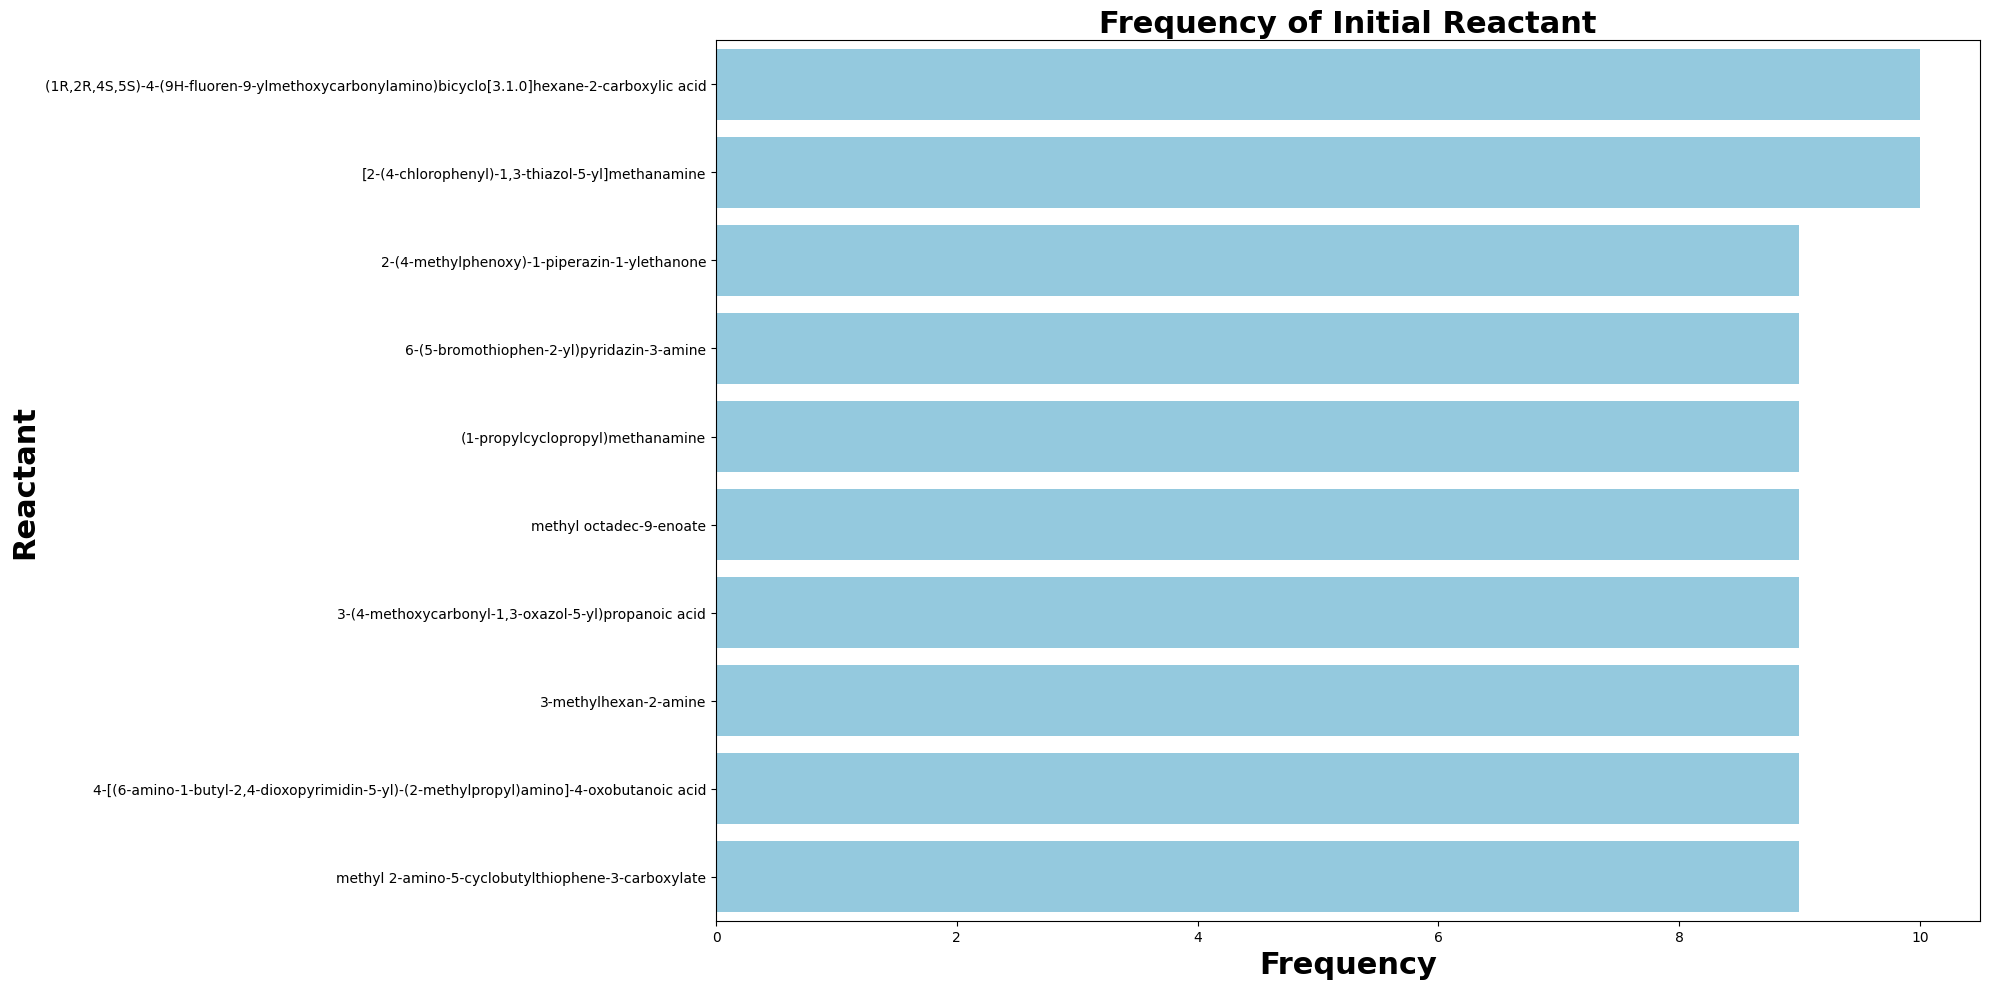

In [41]:
# Filter the DataFrame for step 0
df_step_0 = randomsearch_results[randomsearch_results['step'] == 0]

# Calculate the frequency of each combined reactant
reactant_frequency_step_0 = df_step_0['reactant'].value_counts().reset_index()
reactant_frequency_step_0.columns = ['reactant', 'frequency']
data = reactant_frequency_step_0.head(10)
data["reactant"] = data['reactant'].apply(get_compound_name)

# Create a horizontal bar chart
plt.figure(figsize=(20, 10))
sns.barplot(y='reactant', x='frequency', data=data, color='skyblue')
#plt.xscale('log')
plt.title('Frequency of Initial Reactant', fontsize=22, fontweight='bold')
plt.xlabel('Frequency', fontsize=22, fontweight='bold')
plt.ylabel('Reactant', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

# Greedy Search: 2hrs on 2000 validation set

In [1]:
greedysearch_results = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/src/models/gsearch/results/Gmolsearch_results.csv", index_col=0)
greedysearch_results.describe()

NameError: name 'pd' is not defined

In [6]:
greedysearch_results.head(10)

,step,reactant,template,product,qed,second_reactant
path_id,,,,,,
0,0,CC(C)(C)OC(=O)N[C@@H]1CCC[C@H]1C(=O)O,NaN,CC(C)(C)OC(=O)N[C@@H]1CCC[C@H]1C(=O)O,0.756,NaN
0,1,CC(C)(C)OC(=O)N[C@@H]1CCC[C@H]1C(=O)O,FGA_alpha_bromination,CC(C)(C)OC(=O)N[C@@H]1CCC[C@@]1(Br)C(=O)O,0.767,NaN
0,2,CC(C)(C)OC(=O)N[C@@H]1CCC[C@@]1(Br)C(=O)O,FGI_Acyl_chloride,CC(C)(C)OC(=O)N[C@@H]1CCC[C@@]1(Br)C(=O)Cl,0.627,NaN
1,0,Fc1cc2nccc(Br)c2cc1Cl,NaN,Fc1cc2nccc(Br)c2cc1Cl,0.702,NaN
1,1,Fc1cc2nccc(Br)c2cc1Cl,FGI_Rosenmund-von_Braun,N#Cc1cc2c(Br)ccnc2cc1F,0.721,NaN
2,0,Oc1cc(I)c(Br)n2ccnc12,NaN,Oc1cc(I)c(Br)n2ccnc12,0.591,NaN
2,1,Oc1cc(I)c(Br)n2ccnc12,FGI_chlorination,Clc1cc(I)c(Br)n2ccnc12,0.522,NaN
3,0,C#CCc1ccc(CO)cc1,NaN,C#CCc1ccc(CO)cc1,0.624,NaN
3,1,C#CCc1ccc(CO)cc1,FGI_nitrilation,C#CCc1ccc(C#N)cc1,0.546,NaN


In [8]:
greedysearch_results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169860 entries, 0 to 64859
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   step             169860 non-null  int64  
 1   reactant         169860 non-null  object 
 2   template         105000 non-null  object 
 3   product          169860 non-null  object 
 4   qed              169860 non-null  float64
 5   second_reactant  0 non-null       float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.1+ MB


In [9]:
# Number of paths
len(greedysearch_results.index.unique())

64860

In [13]:
# Molecules with the highest qed regardless of max steps
greedysearch_results[greedysearch_results["qed"]==0.944]

,step,reactant,template,product,qed,second_reactant
path_id,,,,,,
402,1,COc1ccc(Cl)cc1C1(C#N)CCC(C)CC1,Tetrazol_formation,COc1ccc(Cl)cc1C1(c2nn[nH]n2)CCC(C)CC1,0.944,NaN
409,0,Cc1nn(-c2ccc(Cl)cc2Cl)c(C)c1CC(=O)O,NaN,Cc1nn(-c2ccc(Cl)cc2Cl)c(C)c1CC(=O)O,0.944,NaN
731,0,Cc1nn(-c2ccc(Cl)cc2Cl)c(C)c1CC(=O)O,NaN,Cc1nn(-c2ccc(Cl)cc2Cl)c(C)c1CC(=O)O,0.944,NaN
1709,1,COc1ccc(Cl)cc1C1(C#N)CCC(C)CC1,Tetrazol_formation,COc1ccc(Cl)cc1C1(c2nn[nH]n2)CCC(C)CC1,0.944,NaN
1904,1,COc1ccc(Cl)cc1C1(C#N)CCC(C)CC1,Tetrazol_formation,COc1ccc(Cl)cc1C1(c2nn[nH]n2)CCC(C)CC1,0.944,NaN
...,...,...,...,...,...,...
63898,1,COc1ccc(Cl)cc1C1(C#N)CCC(C)CC1,Tetrazol_formation,COc1ccc(Cl)cc1C1(c2nn[nH]n2)CCC(C)CC1,0.944,NaN
64367,1,CC(C)c1cccc(-n2cc(O)c(C(=O)O)n2)c1,FGI_bromination,CC(C)c1cccc(-n2cc(Br)c(C(=O)O)n2)c1,0.944,NaN
64387,0,Cc1nn(-c2ccc(Cl)cc2Cl)c(C)c1CC(=O)O,NaN,Cc1nn(-c2ccc(Cl)cc2Cl)c(C)c1CC(=O)O,0.944,NaN


In [44]:
# Paths that achieved the max number of steps (5)
greedysearch_results[greedysearch_results["step"]==5].sort_values(by='qed', ascending=False).head(20)

,step,reactant,template,product,qed,second_reactant
path_id,,,,,,
31375,5,N#Cc1ccc(Oc2c(C#N)cc(CCC(=O)O)cc2C#N)cc1,FGA_alpha_chlorination,N#Cc1ccc(Oc2c(C#N)cc(CC(Cl)C(=O)O)cc2C#N)cc1,0.825,NaN
37733,5,N#Cc1ccc(Oc2c(C#N)cc(CCC(=O)O)cc2C#N)cc1,FGA_alpha_chlorination,N#Cc1ccc(Oc2c(C#N)cc(CC(Cl)C(=O)O)cc2C#N)cc1,0.825,NaN
44838,5,N#Cc1ccc(Oc2c(C#N)cc(CCC(=O)O)cc2C#N)cc1,FGA_alpha_chlorination,N#Cc1ccc(Oc2c(C#N)cc(CC(Cl)C(=O)O)cc2C#N)cc1,0.825,NaN
44295,5,N#Cc1ccc(Oc2c(C#N)cc(CCC(=O)O)cc2C#N)cc1,FGA_alpha_chlorination,N#Cc1ccc(Oc2c(C#N)cc(CC(Cl)C(=O)O)cc2C#N)cc1,0.825,NaN
41947,5,N#Cc1ccc(Oc2c(C#N)cc(CCC(=O)O)cc2C#N)cc1,FGA_alpha_chlorination,N#Cc1ccc(Oc2c(C#N)cc(CC(Cl)C(=O)O)cc2C#N)cc1,0.825,NaN
41178,5,N#Cc1ccc(Oc2c(C#N)cc(CCC(=O)O)cc2C#N)cc1,FGA_alpha_chlorination,N#Cc1ccc(Oc2c(C#N)cc(CC(Cl)C(=O)O)cc2C#N)cc1,0.825,NaN
39455,5,N#Cc1ccc(Oc2c(C#N)cc(CCC(=O)O)cc2C#N)cc1,FGA_alpha_chlorination,N#Cc1ccc(Oc2c(C#N)cc(CC(Cl)C(=O)O)cc2C#N)cc1,0.825,NaN
38305,5,N#Cc1ccc(Oc2c(C#N)cc(CCC(=O)O)cc2C#N)cc1,FGA_alpha_chlorination,N#Cc1ccc(Oc2c(C#N)cc(CC(Cl)C(=O)O)cc2C#N)cc1,0.825,NaN
37853,5,N#Cc1ccc(Oc2c(C#N)cc(CCC(=O)O)cc2C#N)cc1,FGA_alpha_chlorination,N#Cc1ccc(Oc2c(C#N)cc(CC(Cl)C(=O)O)cc2C#N)cc1,0.825,NaN


In [45]:
# Find the maximum qed value for the last step of each path
last_steps = greedysearch_results.groupby('path_id').apply(lambda x: x[x['step']==x['step'].max()])
max_qed_last_step = last_steps.loc[last_steps['qed'].idxmax()]
max_qed_last_step

step                                                 1
reactant            CC(C)c1cccc(-n2cc(O)c(C(=O)O)n2)c1
template                               FGI_bromination
product            CC(C)c1cccc(-n2cc(Br)c(C(=O)O)n2)c1
qed                                              0.944
second_reactant                                    NaN
Name: (2914, 2914), dtype: object

In [49]:
last_steps.sort_values(by='qed', ascending=False).head(30)

,,step,reactant,template,product,qed,second_reactant
path_id,path_id,,,,,,
33591,33591,1,CC(C)c1cccc(-n2cc(O)c(C(=O)O)n2)c1,FGI_bromination,CC(C)c1cccc(-n2cc(Br)c(C(=O)O)n2)c1,0.944,NaN
11718,11718,1,CC(C)c1cccc(-n2cc(O)c(C(=O)O)n2)c1,FGI_bromination,CC(C)c1cccc(-n2cc(Br)c(C(=O)O)n2)c1,0.944,NaN
59609,59609,1,CC(C)c1cccc(-n2cc(O)c(C(=O)O)n2)c1,FGI_bromination,CC(C)c1cccc(-n2cc(Br)c(C(=O)O)n2)c1,0.944,NaN
62450,62450,1,CC(C)c1cccc(-n2cc(O)c(C(=O)O)n2)c1,FGI_bromination,CC(C)c1cccc(-n2cc(Br)c(C(=O)O)n2)c1,0.944,NaN
12479,12479,1,CC(C)c1cccc(-n2cc(O)c(C(=O)O)n2)c1,FGI_bromination,CC(C)c1cccc(-n2cc(Br)c(C(=O)O)n2)c1,0.944,NaN
14300,14300,1,CC(C)c1cccc(-n2cc(O)c(C(=O)O)n2)c1,FGI_bromination,CC(C)c1cccc(-n2cc(Br)c(C(=O)O)n2)c1,0.944,NaN
2914,2914,1,CC(C)c1cccc(-n2cc(O)c(C(=O)O)n2)c1,FGI_bromination,CC(C)c1cccc(-n2cc(Br)c(C(=O)O)n2)c1,0.944,NaN
51932,51932,1,CC(C)c1cccc(-n2cc(O)c(C(=O)O)n2)c1,FGI_bromination,CC(C)c1cccc(-n2cc(Br)c(C(=O)O)n2)c1,0.944,NaN
55857,55857,1,CC(C)c1cccc(-n2cc(O)c(C(=O)O)n2)c1,FGI_bromination,CC(C)c1cccc(-n2cc(Br)c(C(=O)O)n2)c1,0.944,NaN


In [50]:
last_steps.sort_values(by='qed', ascending=False).tail(10)

,,step,reactant,template,product,qed,second_reactant
path_id,path_id,,,,,,
18570,18570,3,CCCCN(CCCC)CCC(O)c1cc2c(C#N)cc(C#N)cc2c2cc(C(F...,FGI_chlorination,CCCCN(CCCC)CCC(Cl)c1cc2c(C#N)cc(C#N)cc2c2cc(C(...,0.208,NaN
12706,12706,3,CCCCN(CCCC)CCC(O)c1cc2c(C#N)cc(C#N)cc2c2cc(C(F...,FGI_chlorination,CCCCN(CCCC)CCC(Cl)c1cc2c(C#N)cc(C#N)cc2c2cc(C(...,0.208,NaN
29629,29629,3,CCCCN(CCCC)CCC(O)c1cc2c(C#N)cc(C#N)cc2c2cc(C(F...,FGI_chlorination,CCCCN(CCCC)CCC(Cl)c1cc2c(C#N)cc(C#N)cc2c2cc(C(...,0.208,NaN
30832,30832,3,CCCCN(CCCC)CCC(O)c1cc2c(C#N)cc(C#N)cc2c2cc(C(F...,FGI_chlorination,CCCCN(CCCC)CCC(Cl)c1cc2c(C#N)cc(C#N)cc2c2cc(C(...,0.208,NaN
40484,40484,3,CCCCN(CCCC)CCC(O)c1cc2c(C#N)cc(C#N)cc2c2cc(C(F...,FGI_chlorination,CCCCN(CCCC)CCC(Cl)c1cc2c(C#N)cc(C#N)cc2c2cc(C(...,0.208,NaN
56673,56673,3,CCCCN(CCCC)CCC(O)c1cc2c(C#N)cc(C#N)cc2c2cc(C(F...,FGI_chlorination,CCCCN(CCCC)CCC(Cl)c1cc2c(C#N)cc(C#N)cc2c2cc(C(...,0.208,NaN
30828,30828,3,CCCCN(CCCC)CCC(O)c1cc2c(C#N)cc(C#N)cc2c2cc(C(F...,FGI_chlorination,CCCCN(CCCC)CCC(Cl)c1cc2c(C#N)cc(C#N)cc2c2cc(C(...,0.208,NaN
9863,9863,3,CCCCN(CCCC)CCC(O)c1cc2c(C#N)cc(C#N)cc2c2cc(C(F...,FGI_chlorination,CCCCN(CCCC)CCC(Cl)c1cc2c(C#N)cc(C#N)cc2c2cc(C(...,0.208,NaN
41479,41479,3,CCCCN(CCCC)CCC(O)c1cc2c(C#N)cc(C#N)cc2c2cc(C(F...,FGI_chlorination,CCCCN(CCCC)CCC(Cl)c1cc2c(C#N)cc(C#N)cc2c2cc(C(...,0.208,NaN


In [47]:
# Calculate the number of unique products
unique_products_count = greedysearch_results['product'].nunique()

# Display the result
print(f'The number of non-repetitive (unique) products is: {unique_products_count}')

The number of non-repetitive (unique) products is: 2588


In [48]:
# Filter the DataFrame for step 0
df_step_0 = greedysearch_results[greedysearch_results['step'] == 0]


# Calculate the number of unique reactants
unique_reactants_count_step_0 = df_step_0["reactant"].nunique()

# Display the result
print(f'The number of unique initial reactants in is: {unique_reactants_count_step_0}')

The number of unique initial reactants in is: 990


In [52]:
# display path with highest qed
print_path(greedysearch_results, 33591)

Synthesis Path ID: 33591
Step 0:
  Reactant: CC(C)c1cccc(-n2cc(O)c(C(=O)O)n2)c1 | Name: 4-hydroxy-1-(3-propan-2-ylphenyl)pyrazole-3-carboxylic acid
  Template: nan
  Product: CC(C)c1cccc(-n2cc(O)c(C(=O)O)n2)c1 | Name: 4-hydroxy-1-(3-propan-2-ylphenyl)pyrazole-3-carboxylic acid
  QED Score: 0.872
----------------------------------------
Step 1:
  Reactant: CC(C)c1cccc(-n2cc(O)c(C(=O)O)n2)c1 | Name: 4-hydroxy-1-(3-propan-2-ylphenyl)pyrazole-3-carboxylic acid
  Template: FGI_bromination
  Product: CC(C)c1cccc(-n2cc(Br)c(C(=O)O)n2)c1 | Name: Molecule not in PubChem Database
  QED Score: 0.944
----------------------------------------


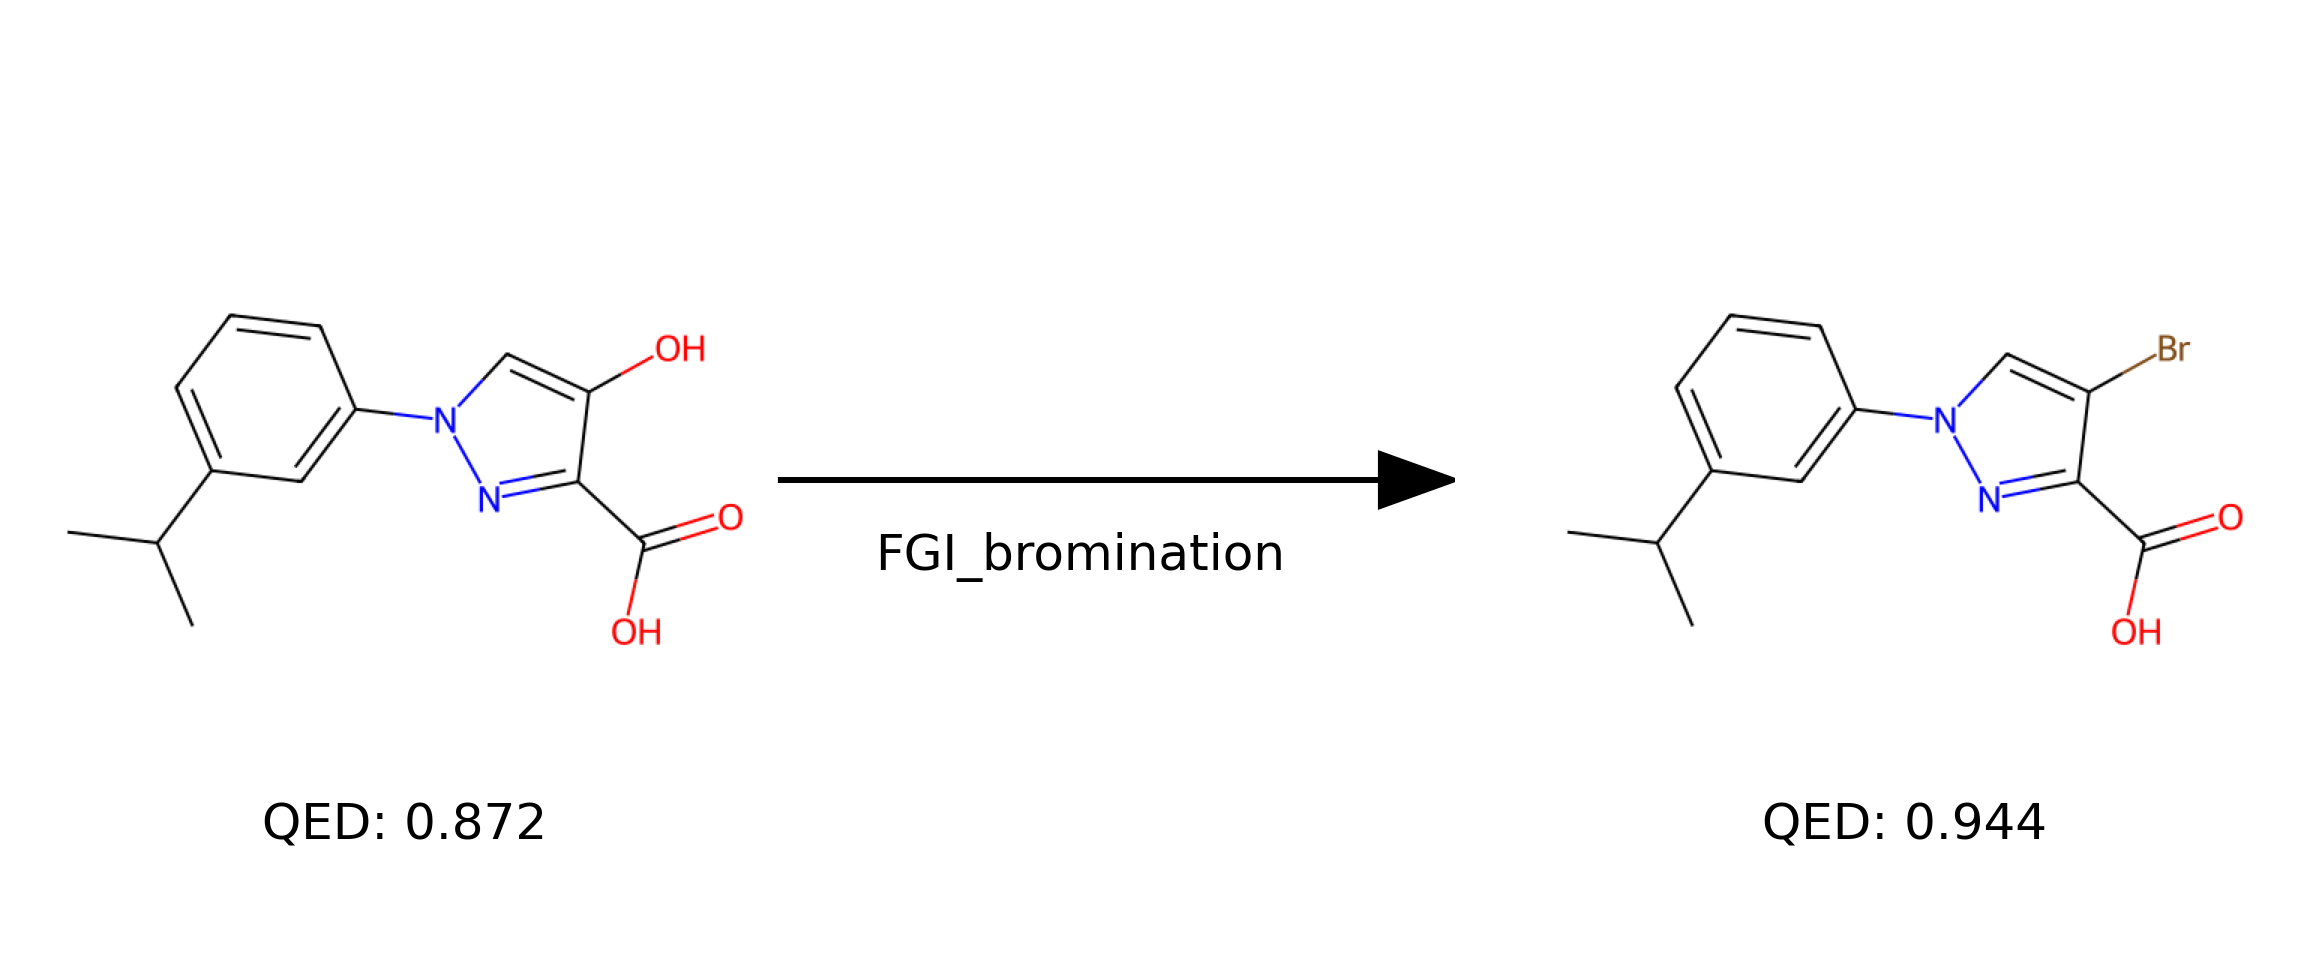

In [58]:
# synthesis path for molecule with highest qed
draw_path(greedysearch_results, 33591)

## Data Analysis

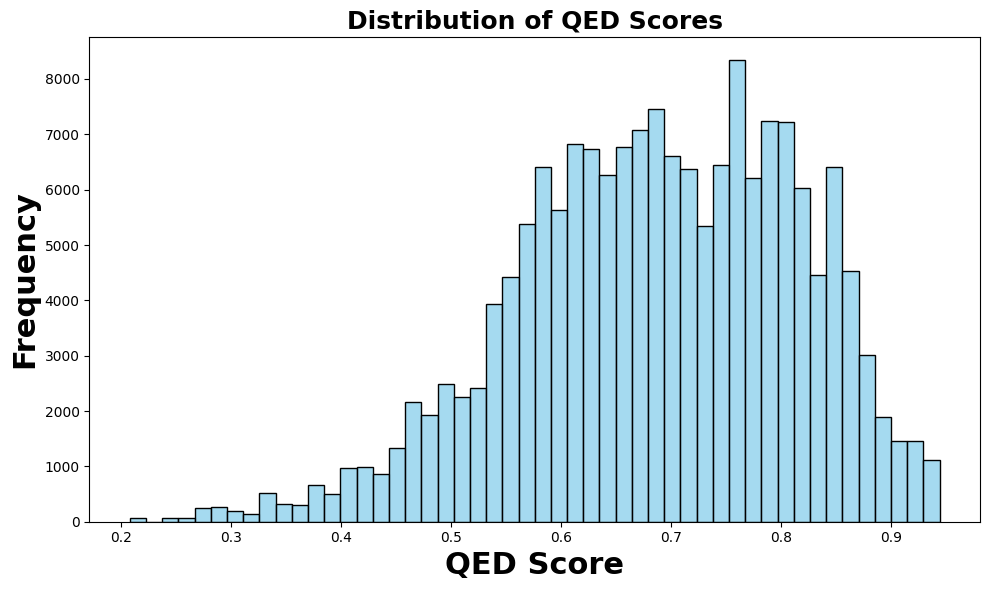

In [54]:
# Distribution of QED scores
plt.figure(figsize=(10, 6))
sns.histplot(greedysearch_results['qed'].dropna(), bins=50, kde=False, color='skyblue')
plt.title('Distribution of QED Scores', fontsize=18, fontweight='bold')
plt.xlabel('QED Score', fontsize=22, fontweight='bold')
plt.ylabel('Frequency', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

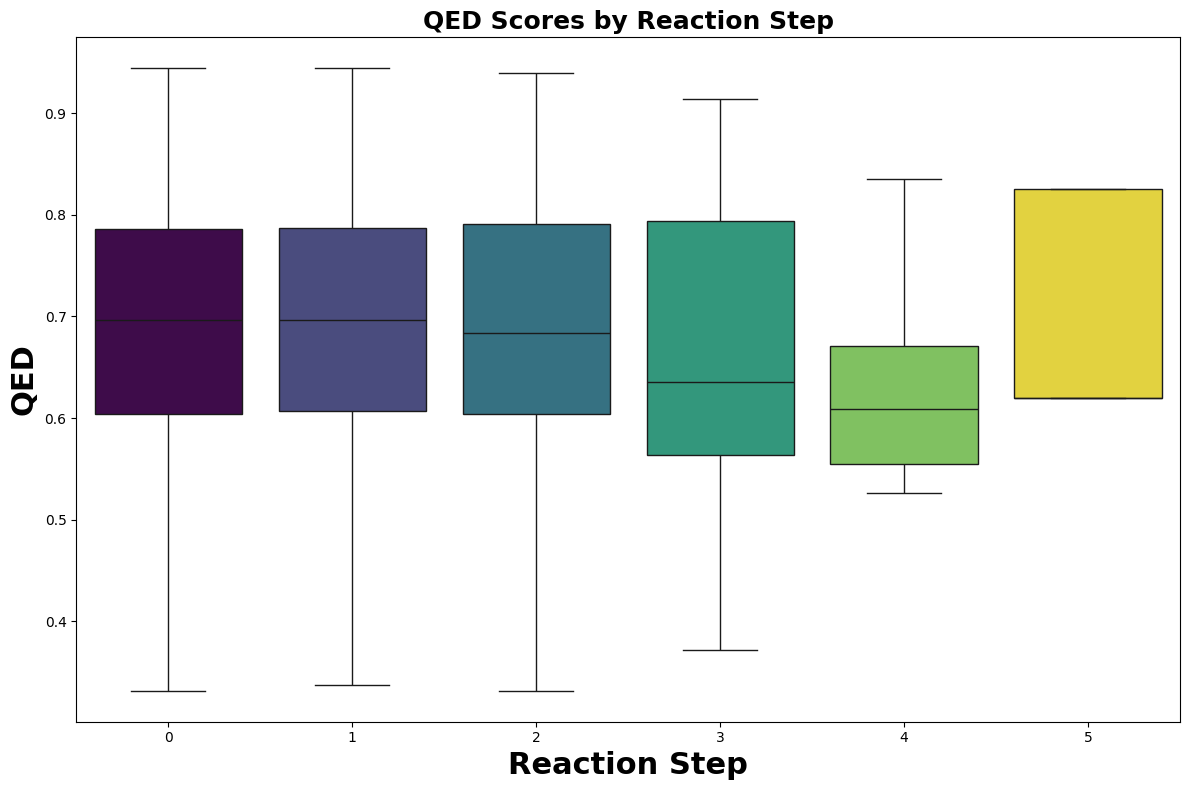

In [55]:
# Box plot for QED scores by reaction step with customized settings to avoid FutureWarning
plt.figure(figsize=(12, 8))
sns.boxplot(x='step', y='qed', data=greedysearch_results, hue='step', palette="viridis", showfliers=False, dodge=False)
plt.legend([], [], frameon=False)  # Remove legend
plt.title('QED Scores by Reaction Step', fontsize=18, fontweight='bold')
plt.xlabel('Reaction Step', fontsize=22, fontweight='bold')
plt.ylabel('QED', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

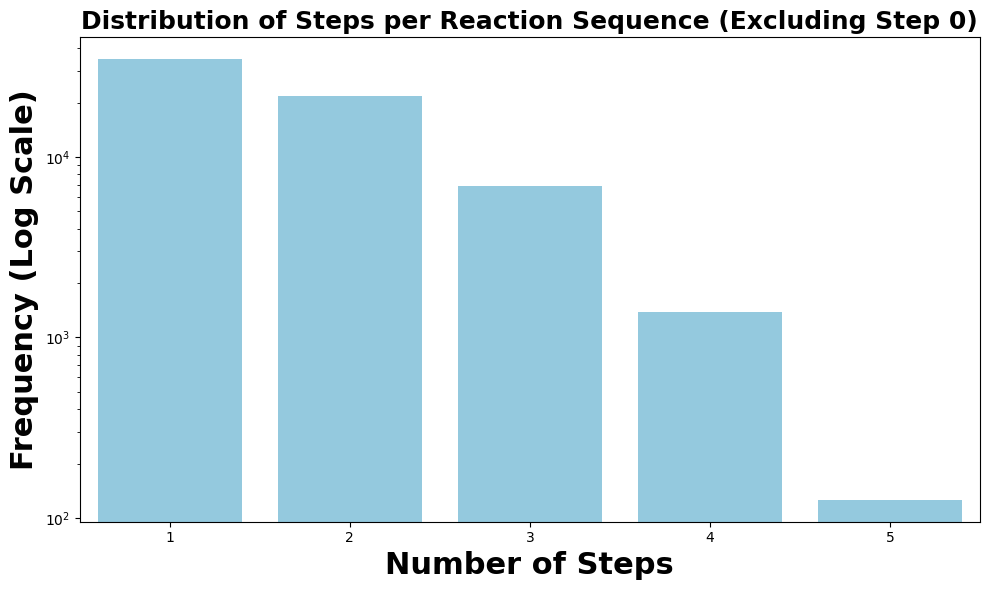

In [56]:
# Filter out step 0
df_filtered = greedysearch_results[greedysearch_results['step'] != 0]

# Calculate the number of steps per reaction sequence
steps_per_sequence = df_filtered.groupby('path_id')['step'].max()

# Calculate the frequency of each number of steps
steps_frequency = steps_per_sequence.value_counts().sort_index()

# Create a bar chart with log scale for frequency
plt.figure(figsize=(10, 6))
sns.barplot(x=steps_frequency.index, y=steps_frequency.values, color='skyblue')
plt.yscale('log')
plt.title('Distribution of Steps per Reaction Sequence (Excluding Step 0)', fontsize=18, fontweight='bold')
plt.xlabel('Number of Steps', fontsize=22, fontweight='bold')
plt.ylabel('Frequency (Log Scale)', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()